# Endogenous Grid Method 

This notebook provides basic implimentation of endogenous grid method.

Our example is income fluctuation problem.


**Reference**

[Pijoan-Mas' note](https://www.cemfi.es/~pijoan/Teaching_files/Notes%20on%20endogenous%20grid%20method.pdf)

In [1]:
using Interpolations
using BenchmarkTools
using Plots
using Profile
using LinearAlgebra
include("mywrapper.jl")
pyplot() # when we use gr() font size of figure is too small.  maybe it will be fixed.

Plots.PyPlotBackend()

In [2]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    
    # primitive params
    β::TF # subjective discount factor
    σ::TF # relative risk aversion
    ϕ::TF # borrowing limit, positive
    
    # asset grid
    a2grid::Array{TF,1}
    na::TI
    # shock grid
    zgrid::Array{TF,2}
    nz::TI
    Π::Array{TF,2}

    # iteration settings
    maxiter::TI
    tol::TF

end

In [3]:
function Construct(β=0.96,
                    σ=3.0,
                    ϕ=0.5,
                    a2min=1e-5,
                    a2max=10.0, 
                    na=100)
    
    
    # create asset grid  a2 = a' + phi
    a_temp  = log.(LinRange(exp(a2min), na, na))
    a2grid = (cumsum(a_temp)/sum(a_temp) * a2max)
    #a2grid = linspace(a2min ,a2max,na) 
    # In Julia v.1.0.0, logspace is depreciated, so we use linspace(my wrapper)
    
    # create shock grid
    zgrid = [0.2  1.0] # productivity shock
    Π =[0.7 0.3; 0.1 0.9] # transition matrix
    nz = size(zgrid,2)
    
    #iteration settings
    tol = 1e-13
    maxiter = 10000
    
    return  Model(β,σ,ϕ,a2grid,na,zgrid,nz,Π,maxiter,tol)  
end

Construct (generic function with 7 methods)

In [4]:
function policyinterp(m::Model,r0::AbstractFloat,w0::AbstractFloat,a1::Array{Float64,2},
                      pol_c::Array{Float64,2},pol_c_u::Array{Float64,2})
    
    #pol_c_u = zeros(m.na,m.nz)
    #Update the consumption policy function
    b = m.a2grid[1]
    @inbounds for (i_z, v_z) in enumerate(m.zgrid)
        @inbounds for (i_a, v_a) in enumerate(m.a2grid)
            if v_a <= a1[1, i_z]; # case where you are constrained
                pol_c_u[i_a, i_z] = (1.0+r0)*v_a + w0*v_z - b

            elseif  v_a >= a1[end, i_z] # out of the range (to the right), linearly extrapolate
                d =(v_a-a1[end, i_z])*(pol_c[end, i_z] - pol_c[end-1, i_z])/(a1[end, i_z]-a1[end-1, i_z])
                pol_c_u[i_a,i_z] = pol_c[end, i_z] +  d
            else # inside the range, linearly interpolate
                @views ind1 = searchsortedfirst(a1[:,i_z], v_a)
                ind  = ind1-1
                d = (v_a-a1[ind, i_z])*(pol_c[ind1, i_z] - pol_c[ind, i_z])/(a1[ind1, i_z]-a1[ind, i_z])
                pol_c_u[i_a, i_z] = pol_c[ind, i_z] + d
            end    
        end
    end
    return pol_c_u
end

policyinterp (generic function with 1 method)

In [5]:
function EGM(m::Model)
    
    # utility function
    #u(c::Float64) = (c^(1.0-m.σ))/(1.0-m.σ)
    u′(c::Float64) = (1.0/c)^(m.σ)
    u′_inv(val::Float64) = val^(-1.0/m.σ)
    # factor price
    r = 0.03 
    w = 1.0 
    
    # for convenience
    a2mat = repeat(m.a2grid,1,2)
    zmat = repeat(m.zgrid ,m.na)

    # initialize asset matrices 
    a1= zeros(m.na,m.nz) # today's asset + ϕ
    wealth = (1.0+r)*a2mat + w*zmat .-r*m.ϕ

    # initialize consumption matrices
    B = zeros(m.na,m.nz) # expected marginal utility matrix in the next period
    ctil =zeros(m.na,m.nz)
    
    # initialize policy functions 
    pol_a =zeros(m.na,m.nz) # policy function for consumption
    pol_c = ones(m.na,m.nz) # initial guess
    pol_c1 =zeros(m.na,m.nz) # policy function for consumption
    
    #=  Solve HH problem=#
    for iter in 1:m.maxiter
        # compute RHS of bellman equation
        B = u′.(pol_c) *(m.β*(1.0+r)*m.Π')
        # compute current consumption
        ctil = u′_inv.(B)

        # compute endogenous asset matrix
        a1 =(a2mat + ctil - w*zmat )./(1.0+r)
        
        # update policy function
        pol_c1 = policyinterp(m,r,w,a1,ctil,pol_c1)
        err = maximum(abs.(pol_c1-pol_c))
        pol_c =copy(pol_c1)

        if err < m.tol
            pol_a = wealth - pol_c
            break
        end
        
    end
   
    return pol_a, pol_c
end

EGM (generic function with 1 method)

In [6]:
m = Construct()
pol_a, pol_c = EGM(m)

([-0.0149997 0.433702; -0.0149997 0.450155; … ; 9.26122 9.97812; 9.386 10.1032], [0.2 0.551298; 0.219628 0.554473; … ; 1.09338 1.17648; 1.099 1.1818])

In [7]:
@time EGM(m);

  0.032962 seconds (5.11 k allocations: 7.385 MiB)


In [8]:
@benchmark EGM(m)

BenchmarkTools.Trial: 
  memory estimate:  7.38 MiB
  allocs estimate:  5102
  --------------
  minimum time:     22.110 ms (0.00% GC)
  median time:      23.667 ms (0.00% GC)
  mean time:        24.827 ms (3.43% GC)
  maximum time:     136.050 ms (69.71% GC)
  --------------
  samples:          202
  evals/sample:     1

In [9]:
agrid =m.a2grid.-m.ϕ;

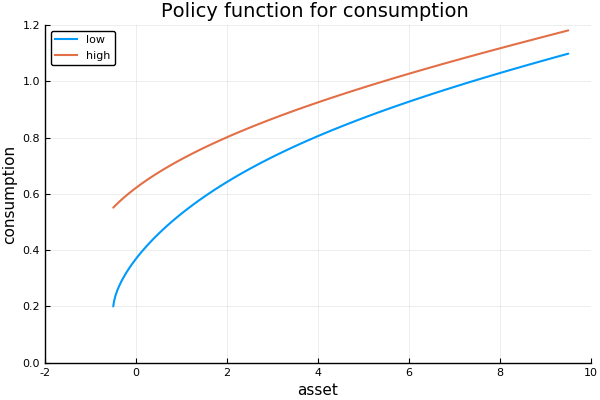

In [10]:
labels = ["low" "high"]
plot(agrid,pol_c, linewidth = 1.5,label=labels,legend=:topleft, ylims=(0,1.2), yticks=0:0.2:1.2,xlims=(-2,10)) 
title!("Policy function for consumption ")
xaxis!("asset")
yaxis!("consumption")

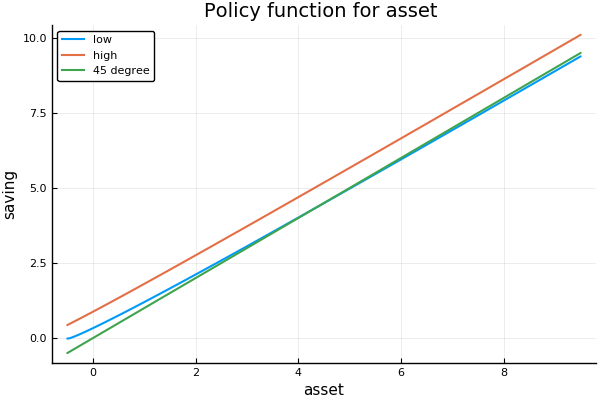

In [11]:
plot(agrid,pol_a,linewidth = 1.5, label = labels,legend=:topleft)
plot!(agrid,agrid,linewidth = 1.5 ,label = "45 degree",legend=:topleft)
title!("Policy function for asset ")
xaxis!("asset")
yaxis!("saving")